In [47]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Setting the ticker symbols for Infosys Stock
stock_ticker='INFY'

# Collect historical data for Infosys
stock = yf.download(stock,start="2021-01-01", end="2023-06-01")
print(data)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2021-01-04  17.389999  17.430000  17.059999  17.250000  16.335627  12597600
2021-01-05  17.320000  17.670000  17.320000  17.650000  16.714422   8109900
2021-01-06  17.400000  17.790001  17.340000  17.730000  16.790182   9136300
2021-01-07  17.360001  17.549999  17.260000  17.549999  16.619724  10272000
2021-01-08  18.070000  18.610001  18.020000  18.590000  17.604597  17802400
...               ...        ...        ...        ...        ...       ...
2023-05-24  15.600000  15.640000  15.490000  15.560000  15.352339   6913200
2023-05-25  15.740000  15.760000  15.520000  15.660000  15.451004   9303400
2023-05-26  15.810000  15.940000  15.790000  15.870000  15.658201   6331800
2023-05-30  15.890000  15.950000  15.830000  15.900000  15.687800   6573500
2023-05-31  15.8000

In [48]:
close_price=stock['Close']

In [49]:
#bollinger band
stock['SMA'] = stock.Close.rolling(20).mean()
AP = (stock.High + stock.Close + stock.Low)/3
SD = AP.rolling(20).std()
stock['upper_bollinger'] = stock['SMA'] + 2*SD
stock['lower_bollinger'] = stock['SMA'] - 2*SD
stock['Signal'] = 'Hold'

In [50]:
#RSI
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

stock['RSI'] = get_rsi(stock['Close'], 20)
stock = stock.dropna()
stock

,Open,High,Low,Close,Adj Close,Volume,SMA,upper_bollinger,lower_bollinger,Signal,RSI
Date,,,,,,,,,,,
2021-02-01,17.190001,17.420000,17.049999,17.379999,16.458735,5829200,17.9495,18.977549,16.921451,Hold,70.896845
2021-02-02,17.450001,17.510000,17.340000,17.440001,16.515554,4119800,17.9590,18.963486,16.954514,Hold,71.176507
2021-02-03,17.600000,17.750000,17.490000,17.650000,16.714426,4677800,17.9590,18.956878,16.961121,Hold,72.162021
2021-02-04,17.540001,17.639999,17.360001,17.590000,16.657604,4439600,17.9520,18.957261,16.946739,Hold,71.427527
2021-02-05,17.500000,17.650000,17.389999,17.629999,16.695484,6952900,17.9560,18.951244,16.960756,Hold,71.630162
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,15.600000,15.640000,15.490000,15.560000,15.352339,6913200,15.3265,15.662568,14.990432,Hold,46.599507
2023-05-25,15.740000,15.760000,15.520000,15.660000,15.451004,9303400,15.3440,15.708219,14.979781,Hold,48.372618
2023-05-26,15.810000,15.940000,15.790000,15.870000,15.658201,6331800,15.3605,15.792763,14.928237,Hold,51.902887


In [57]:
rsi_buy_threshold = 30  
rsi_sell_threshold = 70
buy_signals = (stock['Close'] < stock['lower_bollinger']) & (stock['RSI'] < rsi_buy_threshold)
sell_signals = (stock['Close'] > stock['upper_bollinger']) & (stock['RSI'] > rsi_sell_threshold)
signals = pd.DataFrame(index=stock.index)
signals['Buy_Signal'] = np.where(buy_signals, True, False)
signals['Sell_Signal'] = np.where(sell_signals, True, False)



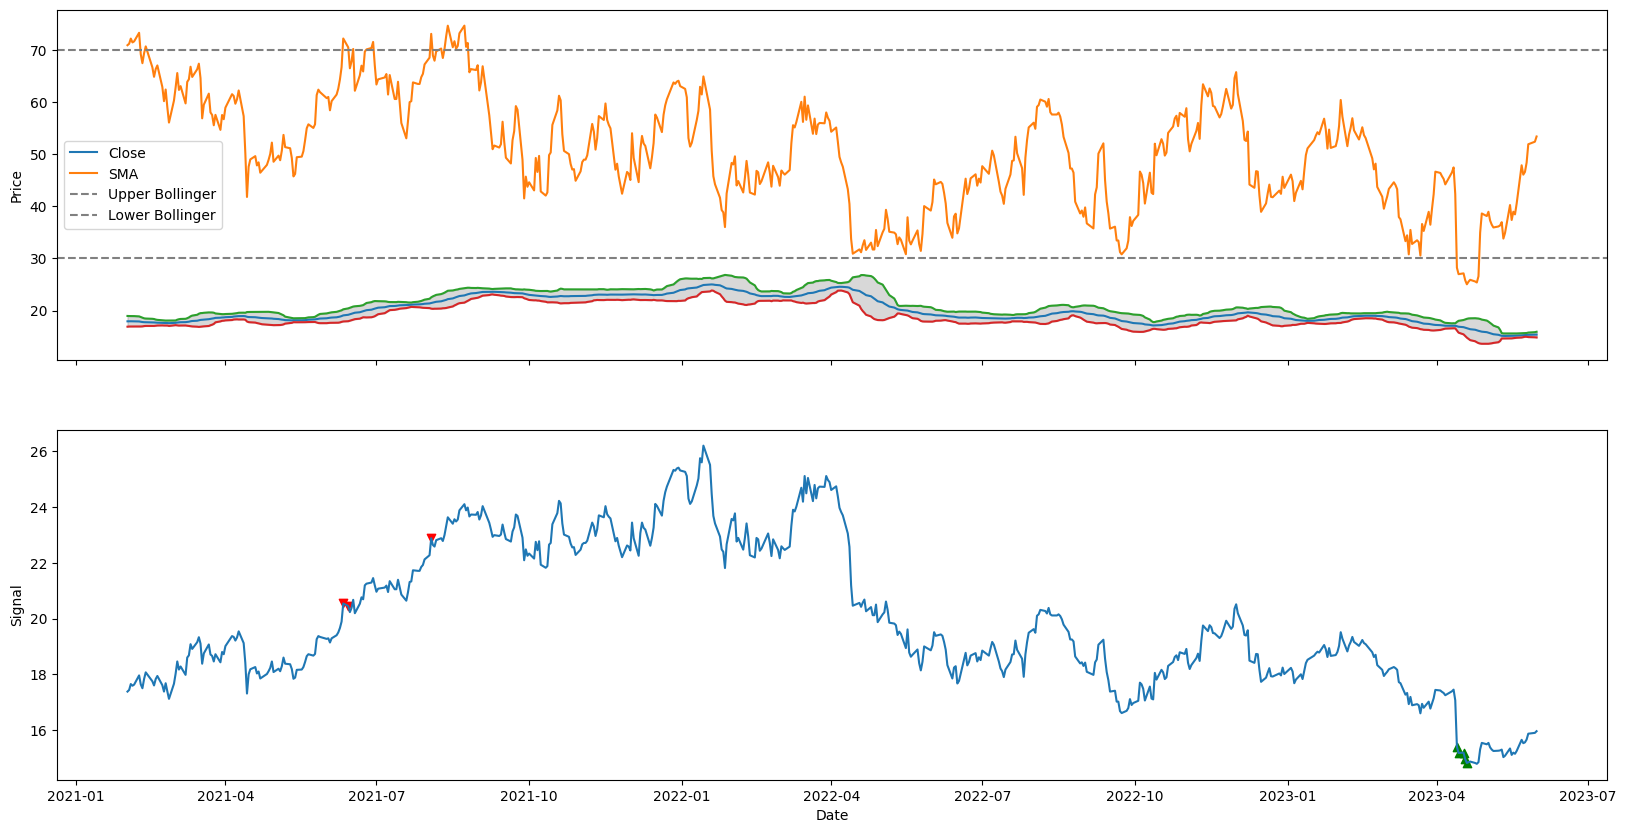

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Plotting the price and Bollinger Bands
ax2.plot(stock['Close'])
ax1.plot(stock['SMA'])
ax1.plot(stock['RSI'])
ax1.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax1.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax1.plot(stock['upper_bollinger'])
ax1.plot(stock['lower_bollinger'])
ax1.fill_between(stock.index, stock['upper_bollinger'], stock['lower_bollinger'], color='grey', alpha=0.3)
ax1.legend(['Close', 'SMA', 'Upper Bollinger', 'Lower Bollinger'])

# Plotting the buy and sell signals
ax2.scatter(stock.index[signals['Buy_Signal']], stock['Close'][signals['Buy_Signal']],marker='^', color='green', label='Buy Signal')
ax2.scatter(stock.index[signals['Sell_Signal']], stock['Close'][signals['Sell_Signal']],marker='v', color='red', label='Sell Signal')

# Setting labels and title
ax1.set_ylabel('Price')
ax2.set_ylabel('Signal')
ax2.set_xlabel('Date')

plt.show()


-0.5135099294254746


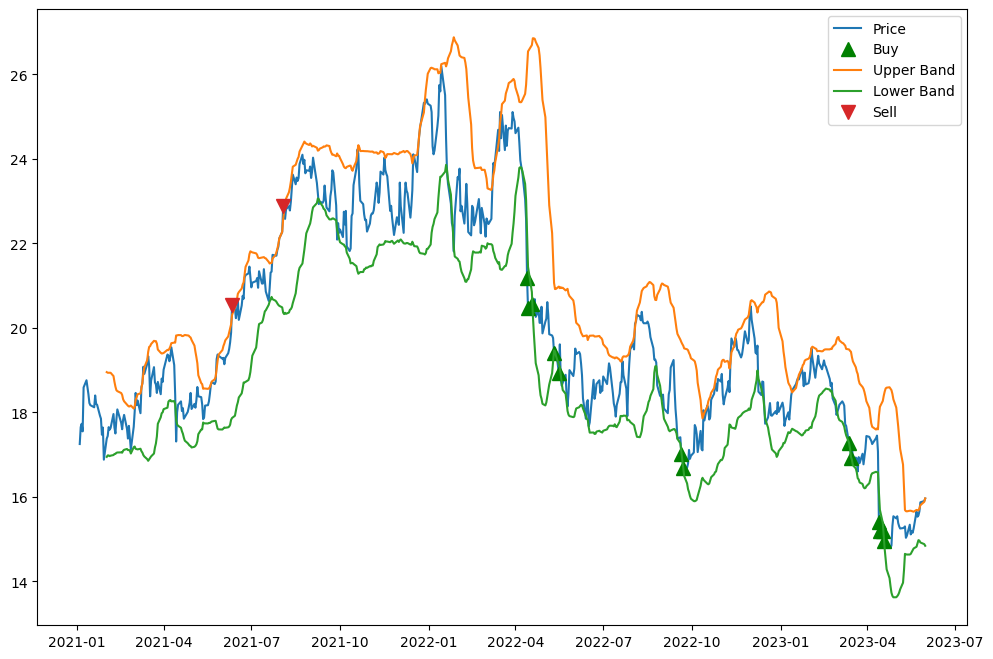

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data['Close'], label='Price')
ax.plot(data.index[buy_signals], data['Close'][buy_signals], '^', markersize=10, color='g', label='Buy')
ax.plot(data.index, calculate_bollinger_bands(data['Close'], window_bb, num_std)[0], label='Upper Band')
ax.plot(data.index, calculate_bollinger_bands(data['Close'], window_bb, num_std)[1], label='Lower Band')
ax.plot(data.index[sell_signals], data['Close'][sell_signals], 'v', markersize=10,label='Sell')
ax.legend()